# Comparison with GroundTruth

In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

In [32]:
import neptune
from MODULES.vae_model import *
from MODULES.utilities_visualization import show_batch, plot_tiling, plot_label_contours
from MODULES.utilities_visualization import plot_segmentation, movie_from_resolution_sweep
from MODULES.graph_clustering import GraphSegmentation
from MODULES.utilities import QC_on_integer_mask, concordance_integer_masks, load_json_as_dict, load_obj
from MODULES.utilities_visualization import contours_from_labels, add_red_contours
import skimage.io
from IPython.display import HTML
from matplotlib import animation

# Check versions
import torch
import numpy
from platform import python_version
print("python_version() ---> ", python_version())
print("torch.__version__ --> ", torch.__version__)

# make sure to fix the randomness at the very beginning
torch.manual_seed(0)
numpy.random.seed(0)

python_version() --->  3.8.2
torch.__version__ -->  1.6.0


### Read the input 

In [39]:
RUN="./RUN_322/"
params = load_json_as_dict(RUN+"ML_parameters.json")
preprocessed = load_obj(RUN+"data_train.pt")
ckpt = file2ckpt(path=RUN+"last_ckpt.pt", device='cpu')
tiling = load_obj(RUN+"tiling.pt")

img_torch = preprocessed.img.float()
roi_mask_torch = preprocessed.roi_mask.bool()

vae = CompositionalVae(params)
load_from_ckpt(ckpt=ckpt,
               model=vae,
               optimizer=None,
               overwrite_member_var=False)

### Select the image to segment

1


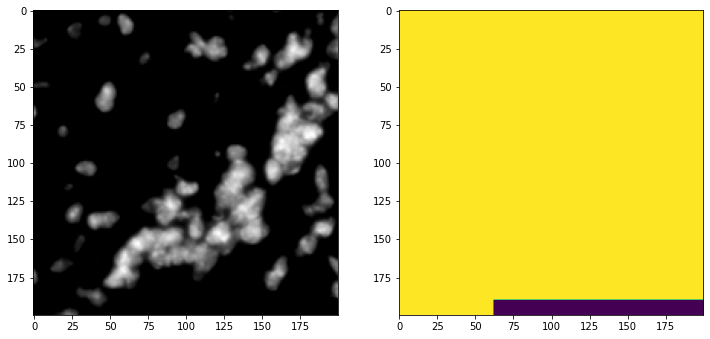

In [40]:
factor_wrt_8 = params["input_image"]["factor_wrt_8"]
print(factor_wrt_8)
#ix_start, iy_start, delta = 940, 2140, 300
#i1 = ix_start * factor_wrt_8
#i2 = i1 + factor_wrt_8 * delta
#j1 = iy_start * factor_wrt_8
#j2 = j1 + factor_wrt_8 * delta

ix_start, iy_start, delta = 1040, 2140, 200
i1 = ix_start * factor_wrt_8
i2 = i1 + factor_wrt_8 * delta
j1 = iy_start * factor_wrt_8
j2 = j1 + factor_wrt_8 * delta

img_to_segment = img_torch[0, :, i1:i2, j1:j2]
roi_mask_to_segment = roi_mask_torch[0, :, i1:i2, j1:j2]

fig, ax = plt.subplots(ncols=2, figsize=(12,12))
ax[0].imshow(img_to_segment[0], cmap='gray')
ax[1].imshow(roi_mask_to_segment[0])

In [36]:
#tmp = skimage.util.img_as_ubyte(img_to_segment[0])
#skimage.io.imsave("try_nucleaizer.png", tmp)
#
#tmp = skimage.util.img_as_float(img_to_segment[0])
#skimage.io.imsave("try_nucleaizer.tiff", tmp)
#
#plt.imshow(tmp)

### Compute the tiling

In [41]:
#tiling = load_obj("tiling.pt")
#tiling: Segmentation = vae.segment_with_tiling(single_img=img_to_segment,
#                                               roi_mask=roi_mask_to_segment,
#                                               crop_size=None,
#                                               stride=(40, 40),
#                                               n_objects_max_per_patch=None,
#                                               prob_corr_factor=None,
#                                               overlap_threshold=None,
#                                               radius_nn=10,
#                                               batch_size=64)
#save_obj(tiling, "tiling.pkl")
tiling_fig = plot_tiling(tiling, neptune_name=None)

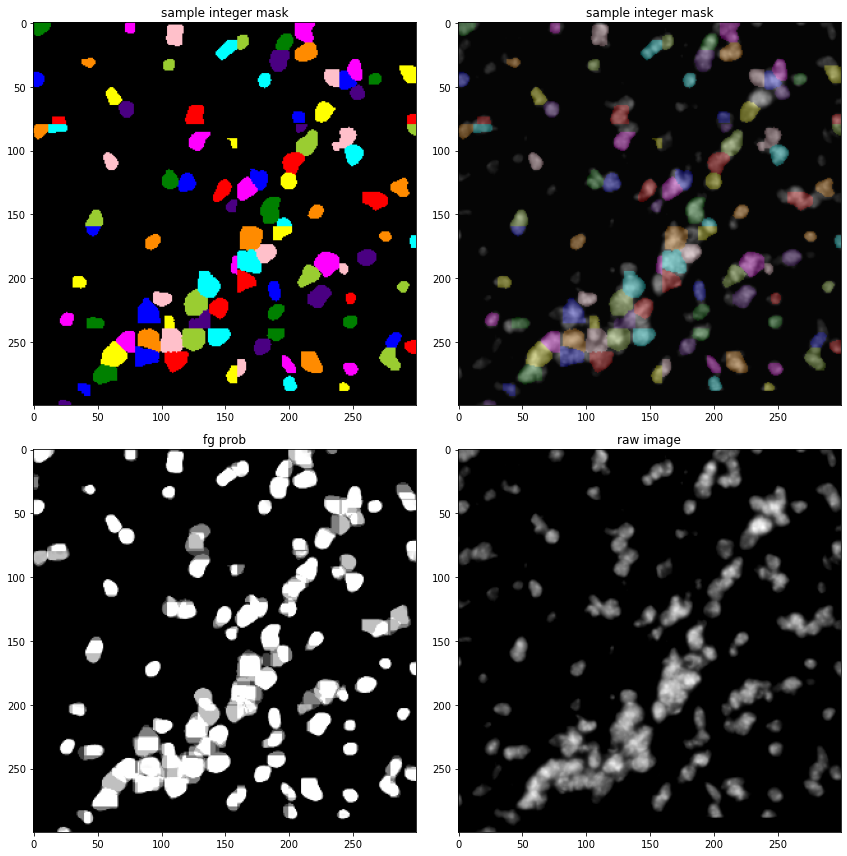

In [42]:
tiling_fig

### Make the graph

WARNING! You are going to create a graph without normalizing the edges by the sqrt of the node degree.                        Are you sure you know what you are doing?!
Building the graph with python-igraph


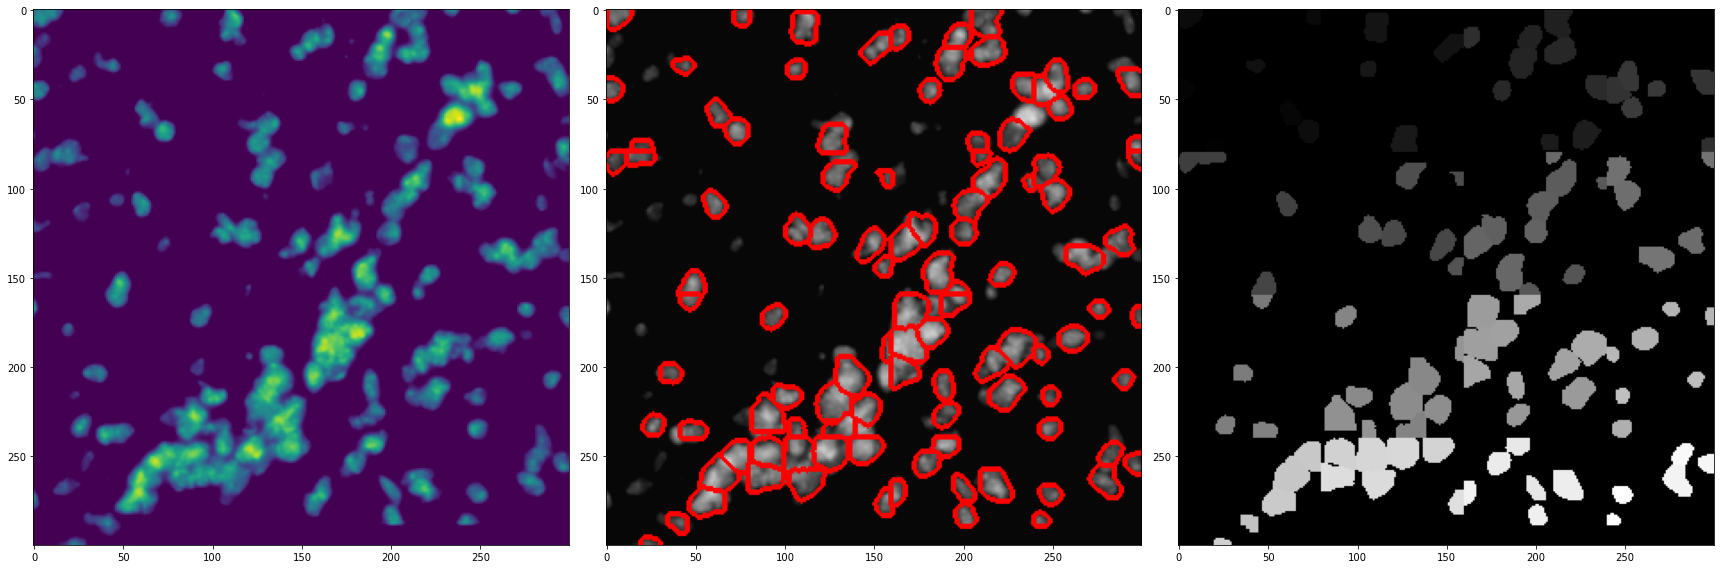

In [43]:
g = GraphSegmentation(tiling, min_fg_prob=0.1, min_edge_weight=0.01, normalize_graph_edges=False)
plot_label_contours(label=g.example_integer_mask,
                    image=tiling.raw_image[0, 0],
                    contour_thickness=2,
                    neptune_name=None) #"tiling_contours_graph")

find partition internal


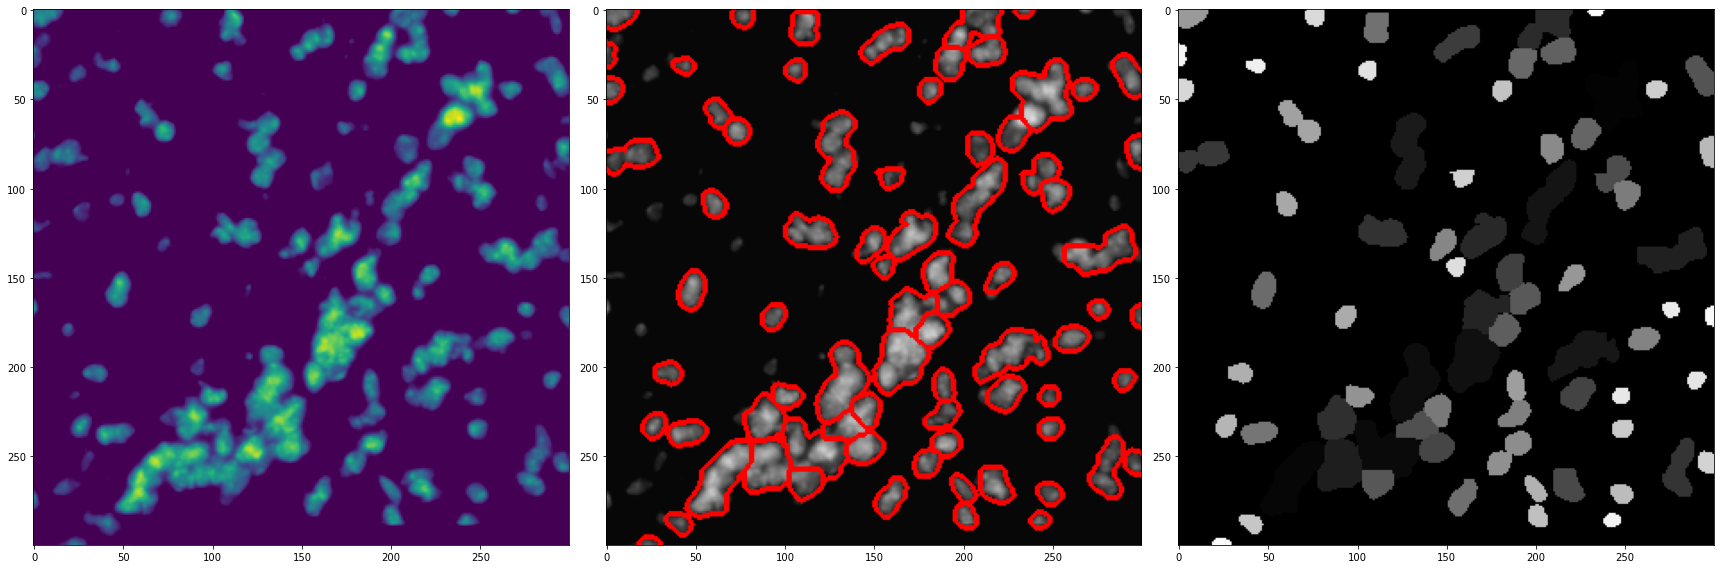

In [44]:
p_mod_false = g.find_partition_leiden(resolution=1.0,
                                      window=None,
                                      min_size=30,
                                      cpm_or_modularity="modularity",
                                      each_cc_separately=False,
                                      n_iterations=10,
                                      initial_membership=None)
plot_label_contours(label=g.partition_2_integer_mask(p_mod_false),
                    image=tiling.raw_image[0, 0],
                    contour_thickness=2,
                    neptune_name=None) #"tiling_contours_graph")

find partition internal


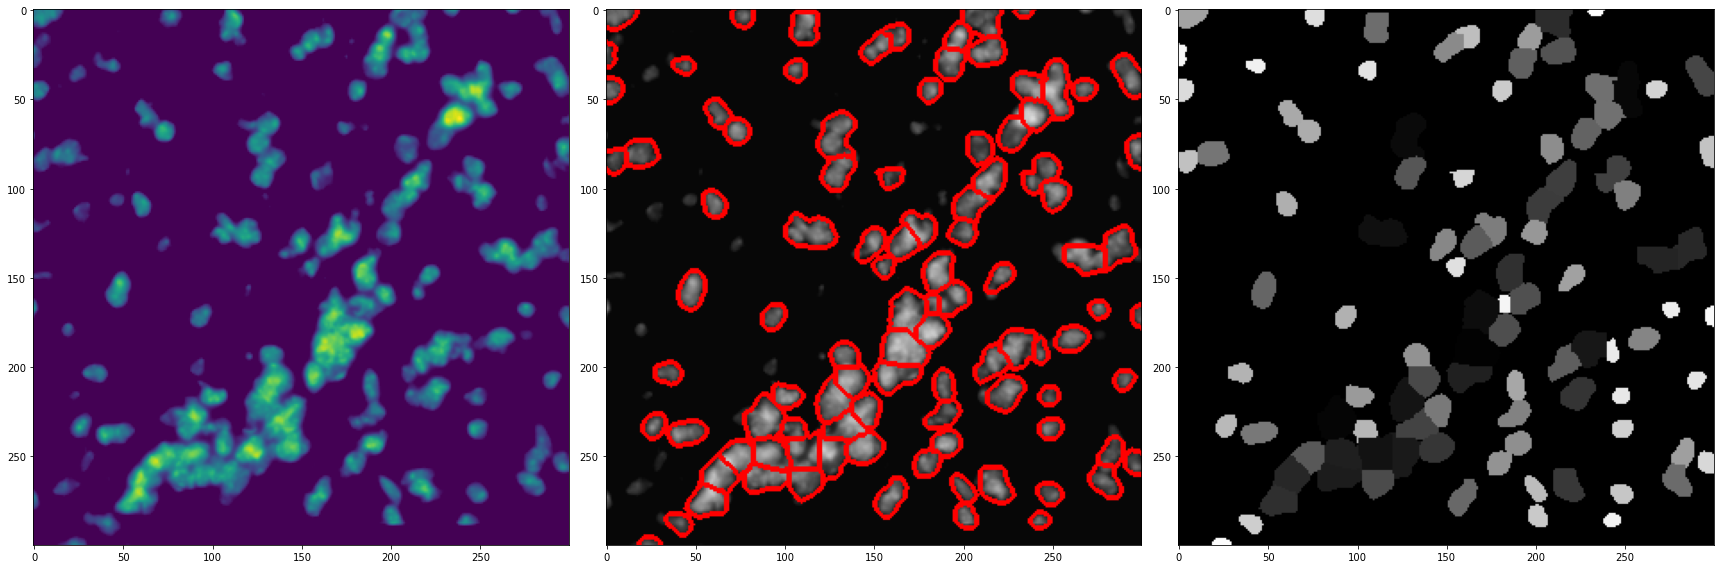

In [45]:
p_mod_false = g.find_partition_leiden(resolution=10.0,
                                      window=None,
                                      min_size=30,
                                      cpm_or_modularity="modularity",
                                      each_cc_separately=False,
                                      n_iterations=10,
                                      initial_membership=None)
plot_label_contours(label=g.partition_2_integer_mask(p_mod_false),
                    image=tiling.raw_image[0, 0],
                    contour_thickness=2,
                    neptune_name=None) #"tiling_contours_graph")

find partition internal


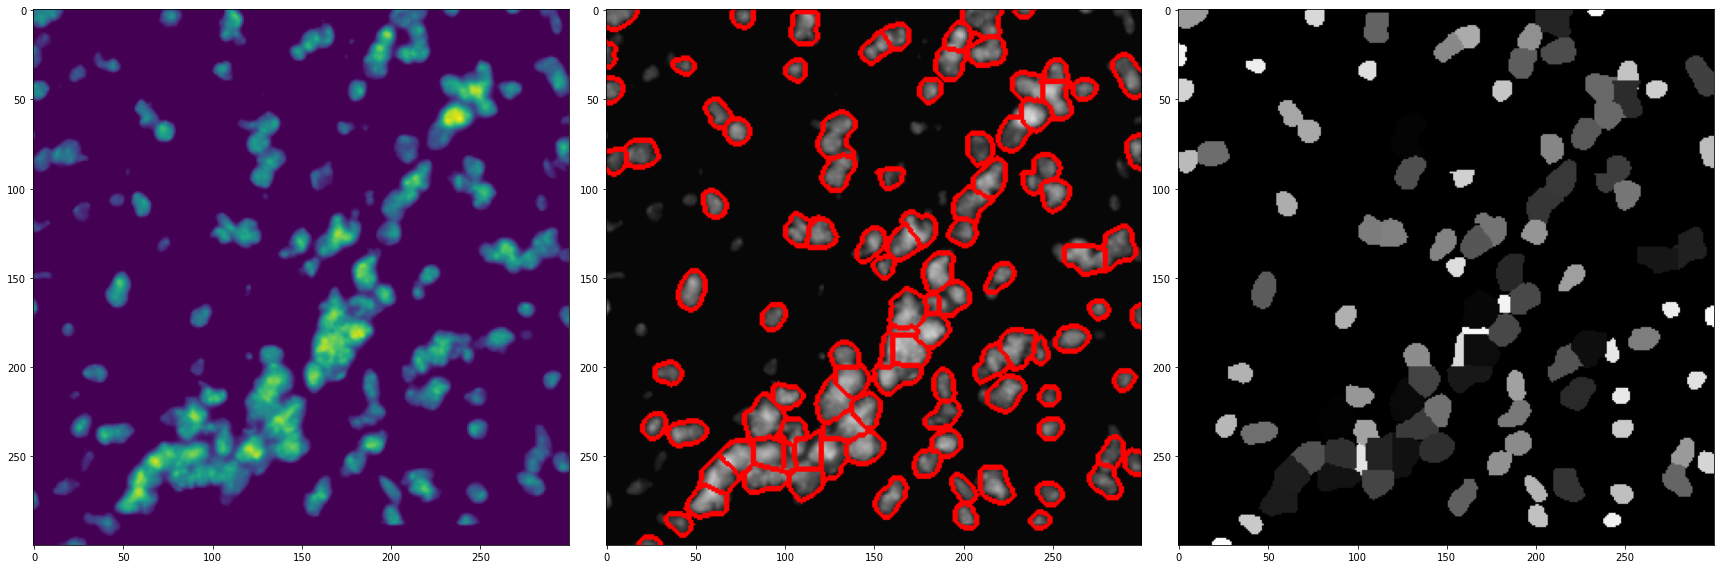

In [46]:
p_mod_false = g.find_partition_leiden(resolution=20.0,
                                      window=None,
                                      min_size=30,
                                      cpm_or_modularity="modularity",
                                      each_cc_separately=False,
                                      n_iterations=10,
                                      initial_membership=None)
plot_label_contours(label=g.partition_2_integer_mask(p_mod_false),
                    image=tiling.raw_image[0, 0],
                    contour_thickness=2,
                    neptune_name=None) #"tiling_contours_graph")

### Parameter sweep

In [58]:
sweep = numpy.arange(1.0, 50.0)
print(len(sweep))

49


In [59]:
g_false = GraphSegmentation(tiling, min_fg_prob=0.1, min_edge_weight=0.01, normalize_graph_edges=False)
suggestion_mod_false = g_false.suggest_resolution_parameter(min_size=20,
                                                      cpm_or_modularity="modularity",
                                                      each_cc_separately=False,
                                                      sweep_range=sweep)
suggestion_cpm_false = g_false.suggest_resolution_parameter(min_size=20,
                                                      cpm_or_modularity="cpm",
                                                      each_cc_separately=False,
                                                      sweep_range=sweep)

WARNING! You are going to create a graph without normalizing the edges by the sqrt of the node degree.                        Are you sure you know what you are doing?!
Building the graph with python-igraph
resolution sweep,   0 out of  48
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
resolution sweep,  10 out of  48
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
resolution sweep,  20 out of  48
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition interna

In [60]:
g_true = GraphSegmentation(tiling, min_fg_prob=0.1, min_edge_weight=0.01, normalize_graph_edges=True)
suggestion_mod_true = g_true.suggest_resolution_parameter(min_size=20,
                                                      cpm_or_modularity="modularity",
                                                      each_cc_separately=False,
                                                      sweep_range=sweep)
suggestion_cpm_true = g_true.suggest_resolution_parameter(min_size=20,
                                                      cpm_or_modularity="cpm",
                                                      each_cc_separately=False,
                                                      sweep_range=sweep)

Building the graph with python-igraph
resolution sweep,   0 out of  48
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
resolution sweep,  10 out of  48
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
resolution sweep,  20 out of  48
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
resolution sweep,  30 out of  48
find partition internal
find partition internal
find partition internal
find partition internal
find partition

### Visualize the sweeps

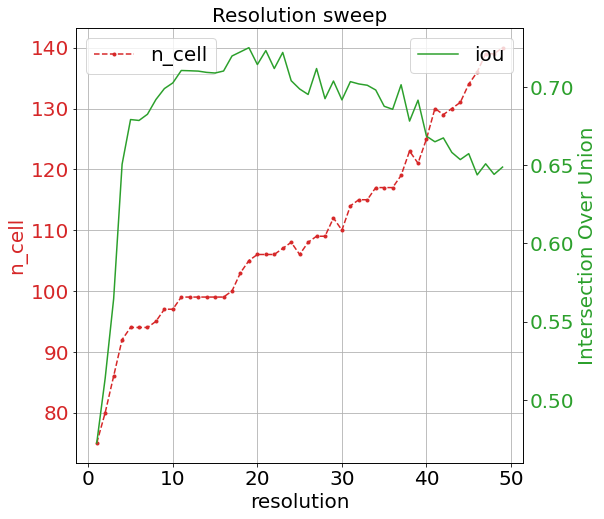

In [65]:
suggestion_cpm_true.show_graph(figsize=(8,8))

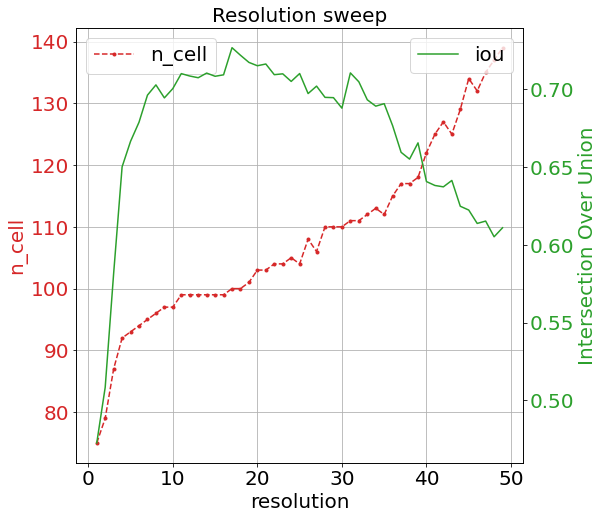

In [62]:
suggestion_mod_true.show_graph(figsize=(8,8))

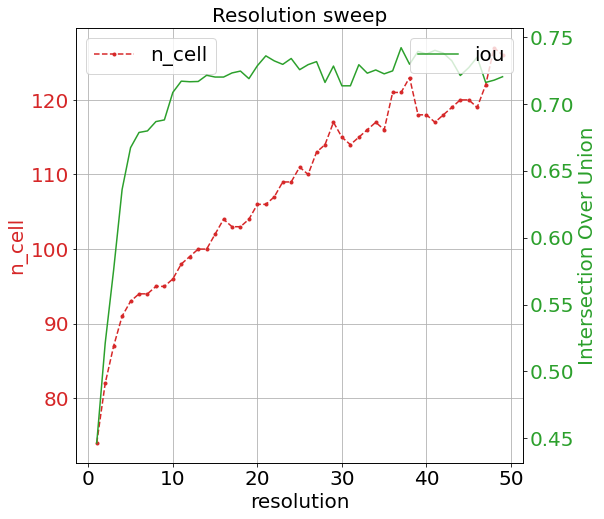

In [63]:
suggestion_cpm_false.show_graph(figsize=(8,8))

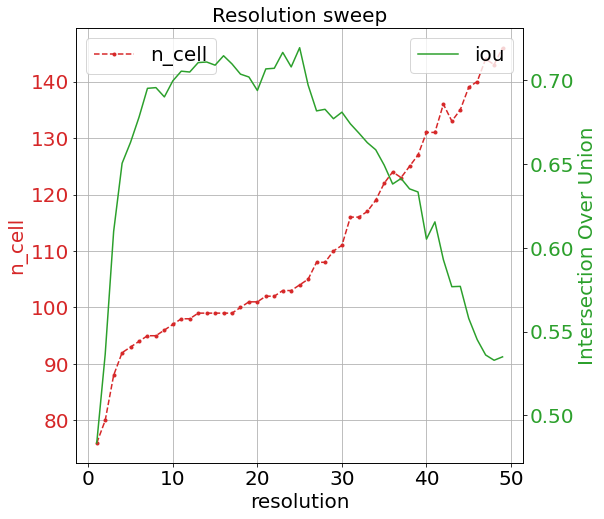

In [64]:
suggestion_mod_false.show_graph(figsize=(8,8))

### Movies

In [66]:
movie_from_resolution_sweep(suggestion_cpm_false, tiling.raw_image[0,0])

In [67]:
movie_from_resolution_sweep(suggestion_cpm_true, tiling.raw_image[0,0])

In [68]:
movie_from_resolution_sweep(suggestion_mod_true, tiling.raw_image[0,0])

In [69]:
movie_from_resolution_sweep(suggestion_mod_false, tiling.raw_image[0,0])

### Helper functions

In [ ]:
suggestion_cpm.show_graph(figsize=(8,8))

In [ ]:
suggestion_cpm.show_best(figsize=(8,8))

In [ ]:
suggestion_cpm.show_index(index=-4, figsize=(8,8))

### Helper functions

### Open the files

In [ ]:
image_file = "smFISH_stitched_OLEH.tif"
oleh_file = "smFISH-full_result_mask.tif"
luca_file = "segmentation_res800.tiff"
gt_file = "manual_annotation_aligned.tif"

raw_img = skimage.img_as_ubyte(skimage.exposure.rescale_intensity(skimage.io.imread(image_file)))
luca_small = skimage.io.imread(luca_file).astype(numpy.uint16)
oleh_img = skimage.io.imread(oleh_file).astype(numpy.uint16)
gt_img = skimage.io.imread(gt_file).astype(numpy.uint16)


# gt_file_transpose = "segmentation_labels_from_json_transposed.tiff"
#dx=50
#dy=-100
#gt_img = skimage.io.imread(gt_file_transpose).astype(numpy.uint16).T
#gt_shifted = numpy.roll(numpy.roll(gt_img, dx, axis=0), dy, axis=1)[-raw_img.shape[0]:,:raw_img.shape[1]]
#skimage.io.imsave("manual_annotation_aligned.tif", gt_shifted, plugin=None, check_contrast=True)

In [ ]:
def add_contours(labels, img):
    c = contours_from_labels(labels, thickness=10)
    #return add_red_contours(img, c)
    tmp = numpy.copy(img)
    tmp[c]=numpy.max(img)
    return tmp

fig, axes = plt.subplots(ncols=2, figsize=(24,24))
axes[0].imshow(add_contours(oleh_img[-5000:,5000:10000], raw_img[-5000:,5000:10000]), cmap='gray')

axes[1].imshow(skimage.color.label2rgb(oleh_img[-5000:,5000:10000],
                                    contours_from_labels(gt_img[-5000:,5000:10000], 10),
                                    alpha=0.25,
                                    bg_label=0))

In [ ]:
raw_small = skimage.transform.rescale(raw_img, scale=0.125,
                                      order=0, 
                                      clip=True, preserve_range=True).astype(numpy.uint16)
gt_small = skimage.transform.rescale(gt_img, scale=0.125,
                                     order=0, 
                                     clip=True, preserve_range=True).astype(numpy.uint16)
oleh_small = skimage.transform.rescale(oleh_img, scale=0.125,
                                      order=0, 
                                      clip=True, preserve_range=True).astype(numpy.uint16)
skimage.io.imsave("raw_small.tif", raw_small, plugin=None, check_contrast=True)
skimage.io.imsave("gt_small.tif", gt_small, plugin=None, check_contrast=True)
skimage.io.imsave("oleh_small.tif", oleh_small, plugin=None, check_contrast=True)

In [ ]:
raw_medium = skimage.transform.rescale(raw_img, scale=0.25,
                                      order=0, 
                                      clip=True, preserve_range=True).astype(numpy.uint16)
gt_medium = skimage.transform.rescale(gt_img, scale=0.25,
                                     order=0, 
                                     clip=True, preserve_range=True).astype(numpy.uint16)
oleh_medium = skimage.transform.rescale(oleh_img, scale=0.25,
                                      order=0, 
                                      clip=True, preserve_range=True).astype(numpy.uint16)
skimage.io.imsave("raw_medium.tif", raw_medium, plugin=None, check_contrast=True)
skimage.io.imsave("gt_medium.tif", gt_medium, plugin=None, check_contrast=True)
skimage.io.imsave("oleh_medium.tif", oleh_medium, plugin=None, check_contrast=True)

In [ ]:
print(gt_small.shape)
print(raw_small.shape)
print(luca_small.shape)
print(oleh_small.shape)

fig, axes = plt.subplots(ncols=4, figsize=(24,24))
axes[0].imshow(gt_small)
axes[1].imshow(raw_small)
axes[2].imshow(luca_small)
axes[3].imshow(oleh_small)

### Upsample luca's labels to match size of Oleh's labels 

In [ ]:
luca_img = skimage.transform.resize(luca_small, oleh_img.shape,
                                    order=0, 
                                    clip=True, preserve_range=True).astype(numpy.uint16)
print(luca_img.shape, luca_img.dtype)

In [ ]:
luca_small_torch = torch.from_numpy(luca_small.astype(numpy.int32))
luca_img_torch = torch.from_numpy(luca_img.astype(numpy.int32))
oleh_img_torch = torch.from_numpy(oleh_img.astype(numpy.int32))

In [ ]:
# Compute the areas and check nothing went worng during upsampling
luca_small_cells_area = torch.bincount(luca_small_torch.flatten())[1:]
luca_large_cells_area = torch.bincount(luca_img_torch.flatten())[1:]
oleh_large_cells_area = torch.bincount(oleh_img_torch.flatten())[1:]

plt.scatter(luca_small_cells_area,luca_large_cells_area)

### Save both segmentation with red contours 

In [ ]:
# make_and_save_segmentation(file_name="tmp.tiff", 
#                            labels=luca_labels[10000:11000,10000:11000], 
#                            raw_image=raw_img[10000:11000,10000:11000])

In [ ]:
# make_and_save_segmentation(file_name="luca_segmentation.tiff", 
#                            labels=luca_labels, 
#                            raw_image=raw_img)

In [ ]:
# make_and_save_segmentation(file_name="oleh_segmentation.tiff", 
#                            labels=oleh_labels, 
#                            raw_image=raw_img)

# Start the actual comparison

Based on:
1. luca_labels vs oleh_labels
2. luca_cells_area vs oleh_cells_area 

In [ ]:
ROI_mask = skimage.morphology.convex_hull_image(luca_labels > 0)
#plt.imshow(ROI_mask)

In [ ]:
window = make_list_of_windows(ROI_mask, n=4, crop_size=800)
plot_comparison(raw_img, luca_labels, oleh_labels, window=window, figsize=(12,24))

In [ ]:
print("total segmented area: luca, oleh", luca_cells_area.sum(), oleh_cells_area.sum())

fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlabel("cells area")
_ = ax.hist([luca_cells_area,oleh_cells_area], bins=50,label=["luca","oleh"])
_ = ax.legend()
fig.savefig("histo.png", dpi=300)

In [ ]:
float(luca_cells_area.shape[0]) / oleh_cells_area.shape[0]

In [ ]:
ratio_ol = float(oleh_cells_area.sum())/luca_cells_area.sum()
ratio_lo = float(luca_cells_area.sum())/oleh_cells_area.sum()
print(ratio_ol, ratio_lo)

In [ ]:
oleh_cells_area.sum()

In [ ]:
luca_cells_area.sum()

In [ ]:
window = [(8*1000, 8*2100, 8*1300, 8*2400)]
#window = [(8*1000, 8*2100, 8*1100, 8*2200)]

plot_comparison(raw_img, luca_labels, oleh_labels, window=window, figsize=(24,24))

### Compute intersection over union

In [ ]:
luca_labels = luca_img
oleh_labels = oleh_img

import torch 
window = (8*1000, 8*2100, 8*1300, 8*2400)
window = (8*1000, 8*2100, 8*1100, 8*2200)
window = (0,0,luca_labels.shape[0],luca_labels.shape[1])

size = window[2]-window[0]
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

luca_membership = torch.from_numpy(luca_labels[window[0]:window[2],window[1]:window[3]].astype(int)).flatten().to(device)
oleh_membership = torch.from_numpy(oleh_labels[window[0]:window[2],window[1]:window[3]].astype(int)).flatten().to(device)
luca_sizes = torch.bincount(luca_membership)
oleh_sizes = torch.bincount(oleh_membership)

In [ ]:
luca_sizes

In [ ]:
sizes, membership = Partition.compactify(luca_sizes, luca_membership)
luca_partition = Partition(which="luca",
                           membership=membership, # bg=0, fg=1,2,3,.....
                           sizes=sizes,
                           params={"ciap":"ciao"})

sizes, membership = Partition.compactify(oleh_sizes, oleh_membership)
oleh_partition = Partition(which="oleh",
                           membership=membership, # bg=0, fg=1,2,3,.....
                           sizes=sizes,
                           params={"ciap":"ciao"})

In [ ]:
plt.imshow(oleh_partition.membership.view(size,size))

In [ ]:
plt.imshow(luca_partition.membership.view(size,size))

In [ ]:
c = luca_partition.concordance_with_partition(oleh_partition) 

In [ ]:
c.iou

In [ ]:
plt.imshow(luca_partition.membership.view(size,size)==1)

In [ ]:
c

In [ ]:
torch.max(pxy)

In [ ]:
plt.matshow(pxy[1:,1:].T, cmap='gray')

In [ ]:
c_ol = oleh_partition.concordance_with_partition(luca_partition) 

In [ ]:
c_lo = luca_partition.concordance_with_partition(oleh_partition) 

In [ ]:
c_ol.iou

In [ ]:
c_lo.iou

In [ ]:
plt.imshow(oleh_partition.membership.view(size,size))

In [ ]:
plt.imshow(luca_partition.membership.view(size,size))